# Fraud Detection in Credit Card Transactions

## Random Forest

## Versions

In [1]:
import sys
import numpy
import pandas # polars could be more efficient than pandas
import matplotlib
import seaborn
import sklearn
import imblearn

print(f"Python version: {sys.version}")
print(f"Numpy version: {numpy.__version__}")
print(f"Pandas version: {pandas.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {seaborn.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Imbalanced-learn version: {imblearn.__version__}")

Python version: 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:12:04) [Clang 18.1.8 ]
Numpy version: 2.1.0
Pandas version: 2.2.2
Matplotlib version: 3.9.2
Seaborn version: 0.13.2
Scikit-learn version: 1.5.1
Imbalanced-learn version: 0.13.0


### Importing Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN

In [4]:
df1 = pd.read_csv('creditcard_part1.csv')
df2 = pd.read_csv('creditcard_part2.csv')

# merge dataframes
ccdata = pd.concat([df1, df2], ignore_index=True)

## Modeling

### Split

In [17]:
# TODO: Oversampling method (SMOTE, ADASYN, etc.) or use an R-GAN model to generate synthetic data

# In the first step, will focus on recall (sensitivity) for the fraudulent class (Class 1) in the confusion matrix
# Recall = TP / (TP + FN)

In [18]:
X = ccdata.drop('Class', axis=1)
y = ccdata['Class']

# 60% training, 20% validation, 20% testing
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=69, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=69, stratify=y_trainval)

In [19]:
print(f"Normal Transactions in training set (Class = 0):\t{y_train.value_counts()[0]}\t({y_train.value_counts()[0] / len(y_train)*100:.2f}%)")
print(f"Fraudulent Transactions in training set (Class = 1):\t{y_train.value_counts()[1]}\t({y_train.value_counts()[1] / len(y_train)*100:.2f}%)")

Normal Transactions in training set (Class = 0):	170588	(99.83%)
Fraudulent Transactions in training set (Class = 1):	295	(0.17%)


### Decision Tree

In [20]:
# model initialization
dtc = DecisionTreeClassifier(random_state=69, max_depth=15)

# model training
dtc.fit(X_train, y_train)

# prediction on validation set
y_val_pred = dtc.predict(X_val)

In [21]:
# model evaluation on validation set
print(f"Tree depth: {dtc.get_depth()}\n")
print(classification_report(y_val, y_val_pred))

Tree depth: 15

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.80      0.73      0.76        99

    accuracy                           1.00     56962
   macro avg       0.90      0.86      0.88     56962
weighted avg       1.00      1.00      1.00     56962



In [22]:
# prediction on validation set
y_val_pred_dtc = dtc.predict(X_val)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.80      0.73      0.76        99

    accuracy                           1.00     56962
   macro avg       0.90      0.86      0.88     56962
weighted avg       1.00      1.00      1.00     56962



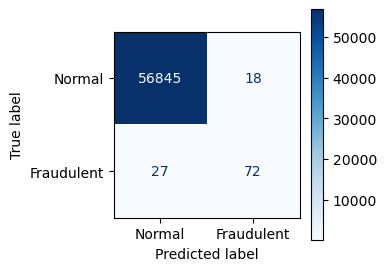

In [23]:
# model evaluation on validation set
print(classification_report(y_val, y_val_pred_dtc))

cm = confusion_matrix(y_val, y_val_pred_dtc)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraudulent'])
fig, ax = plt.subplots(figsize=(3,3))
cm_display.plot(cmap='Blues', ax=ax);


A higher precision and recall for fraudulent cases would be desirable.

### Random Forest

#### Imbalanced

In [24]:
# model initialization
rfc = RandomForestClassifier(random_state=69)

# k-fold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)

In [25]:
# cross validation score
cv_recall = cross_val_score(rfc, X_train, y_train, cv=skf, scoring='recall', n_jobs=-2) # n_jobs=-2 parallelize using all but one CPU core

print(f"Mean Recall: {cv_recall.mean():.2f}") # can expect the performance to be around here

Mean Recall: 0.76


We can expect a recall around 76% for fraudulent cases, which is lower than what we want to achieve.

In [ ]:
# 15-20 min runtime on 7 CPU cores of an intel core i5 processor

# hyperparameters to search
param_grid = {'n_estimators': [50, 100, 150] # number of trees
              ,'max_depth': [5, 10, 15] # maximum depth of the tree
#              ,'max_features': ['auto', 'sqrt', 'log2'] # number of features at each split
             }

# searching best hyperparameters
rfc_random_grid = RandomizedSearchCV(rfc, param_grid, cv=skf, scoring='recall', random_state=69, n_jobs=-2) # n_iter=10 is default
# rfc_grid = GridSearchCV(rfc, param_grid, cv=skf, scoring='recall', n_jobs=-2)

# model training
rfc_random_grid.fit(X_train, y_train)

print(f"Best Parameters:\t{rfc_random_grid.best_params_}")
print(f"Best Recall:\t\t{rfc_random_grid.best_score_:.2f}")

/Users/cedrickeller/anaconda3/envs/cs5831/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters:	{'n_estimators': 50, 'max_depth': 15}
Best Recall:		0.77


In [27]:
# prediction on validation set
y_val_pred_rfc = rfc_random_grid.predict(X_val)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.91      0.76      0.83        99

    accuracy                           1.00     56962
   macro avg       0.96      0.88      0.91     56962
weighted avg       1.00      1.00      1.00     56962



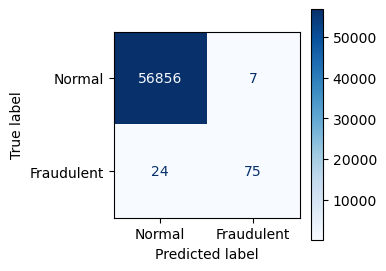

In [28]:
# model evaluation on validation set
print(classification_report(y_val, y_val_pred_rfc))

cm = confusion_matrix(y_val, y_val_pred_rfc)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraudulent'])
fig, ax = plt.subplots(figsize=(3,3))
cm_display.plot(cmap='Blues', ax=ax);

While the recall is higher than expected (80%), the random forest achieves solid precision (94%).

#### Using Undersampling

In [29]:
# undersampling method
rus = RandomUnderSampler(random_state=69)

# resampling
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print(f"Normal Transactions in training set (Class = 0):\t{y_train_under.value_counts()[0]}\t({y_train_under.value_counts()[0] / len(y_train_under)*100:.2f}%)")
print(f"Fraudulent Transactions in training set (Class = 1):\t{y_train_under.value_counts()[1]}\t({y_train_under.value_counts()[1] / len(y_train_under)*100:.2f}%)")

Normal Transactions in training set (Class = 0):	295	(50.00%)
Fraudulent Transactions in training set (Class = 1):	295	(50.00%)


In [30]:
# model initialization
rfc = RandomForestClassifier(random_state=69)

# k-fold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)

In [31]:
# cross validation score
cv_recall = cross_val_score(rfc, X_train_under, y_train_under, cv=skf, scoring='recall', n_jobs=-2) # n_jobs=-2 parallelize using all but one CPU core

print(f"Mean Recall: {cv_recall.mean():.2f}") # can expect the performance to be around here

Mean Recall: 0.88


We can expect an improved recall compared to the imbalanced set.

In [32]:
# hyperparameters to search
param_grid = {'n_estimators': [50, 100, 150] # number of trees
              ,'max_depth': [5, 10, 15] # maximum depth of the tree
#              ,'max_features': ['auto', 'sqrt', 'log2'] # number of features at each split
             }

# searching best hyperparameters
rfc_random_grid_under = RandomizedSearchCV(rfc, param_grid, cv=skf, scoring='recall', random_state=69, n_jobs=-2) # n_iter=10 is default
# rfc_grid = GridSearchCV(rfc, param_grid, cv=skf, scoring='recall', n_jobs=-2)

# model training
rfc_random_grid_under.fit(X_train_under, y_train_under)

print(f"Best Parameters:\t{rfc_random_grid_under.best_params_}")
print(f"Best Recall:\t\t{rfc_random_grid_under.best_score_:.2f}")

/Users/cedrickeller/anaconda3/envs/cs5831/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters:	{'n_estimators': 100, 'max_depth': 10}
Best Recall:		0.89


In [33]:
# prediction on validation set
y_val_pred_rfc_under = rfc_random_grid_under.predict(X_val)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.06      0.92      0.12        99

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962



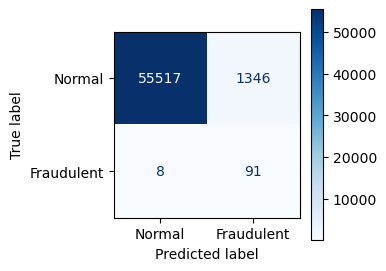

In [34]:
# model evaluation on validation set
print(classification_report(y_val, y_val_pred_rfc_under))

cm = confusion_matrix(y_val, y_val_pred_rfc_under)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraudulent'])
fig, ax = plt.subplots(figsize=(3,3))
cm_display.plot(cmap='Blues', ax=ax);

Undersampling in the random forest achieved good recall (92%), but the precision dropped close to zero (6%). It appears that there is too much loss in information of the normal transactions.

#### Oversampling (ADASYN)

In [35]:
# ADASYN oversampling initialisation
adasyn = ADASYN(sampling_strategy=0.5, random_state=69) # fraudulent cases resampled to 50% of the majority class

# Apply SMOTE on the training data
X_train_over, y_train_over = adasyn.fit_resample(X_train, y_train)


/Users/cedrickeller/anaconda3/envs/cs5831/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


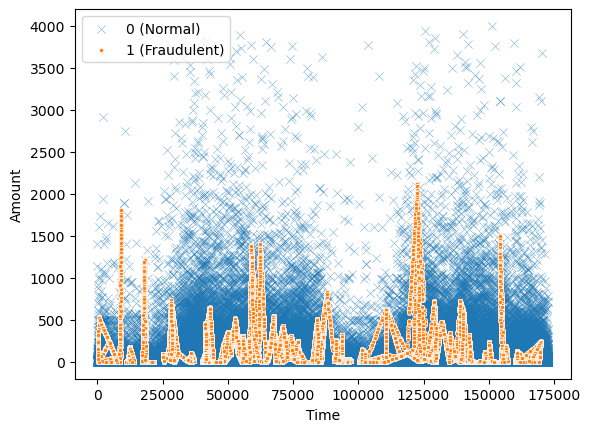

In [36]:
over_df = pd.DataFrame(X_train_over, columns=X_train_over.columns)
over_df['Class'] = y_train_over

sns.scatterplot(data=over_df[(over_df['Amount'] < 4000) & (over_df['Class'] == 0)], y='Amount', x='Time', alpha=0.5, marker='x', label='0 (Normal)')
sns.scatterplot(data=over_df[(over_df['Amount'] < 4000) & (over_df['Class'] == 1)], y='Amount', x='Time', alpha=1, marker='.', label='1 (Fraudulent)', color='tab:orange')
plt.legend();

In [42]:
# model initialization
rfc = RandomForestClassifier(random_state=69)

# k-fold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)

In [38]:
# cross validation score
cv_recall = cross_val_score(rfc, X_train_over, y_train_over, cv=skf, scoring='recall', n_jobs=-2) # n_jobs=-2 parallelize using all but one CPU core

print(f"Mean Recall: {cv_recall.mean():.2f}") # can expect the performance to be around here

Mean Recall: 1.00


In [ ]:
# ~20 min runtime on 7 CPU cores of an intel core i5 processor

# hyperparameters to search
param_grid = {'n_estimators': [50, 100, 150] # number of trees
              ,'max_depth': [5, 10, 15] # maximum depth of the tree
#              ,'max_features': ['auto', 'sqrt', 'log2'] # number of features at each split
             }

# searching best hyperparameters
rfc_random_grid_over = RandomizedSearchCV(rfc, param_grid, cv=skf, scoring='recall', random_state=69, n_jobs=-2) # n_iter=10 is default
# rfc_grid = GridSearchCV(rfc, param_grid, cv=skf, scoring='recall', n_jobs=-2)

# model training
rfc_random_grid_over.fit(X_train_over, y_train_over)

print(f"Best Parameters:\t{rfc_random_grid_over.best_params_}")
print(f"Best Recall:\t\t{rfc_random_grid_over.best_score_:.2f}")

/Users/cedrickeller/anaconda3/envs/cs5831/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters:	{'n_estimators': 50, 'max_depth': 15}
Best Recall:		1.00


In [44]:
# prediction on validation set
y_val_pred_rfc_over = rfc_random_grid_over.predict(X_val)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.84      0.82      0.83        99

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



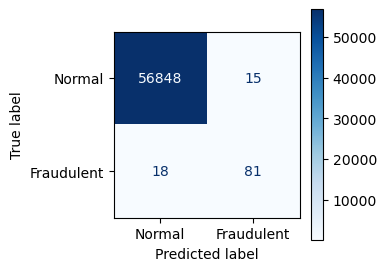

In [45]:
# model evaluation on validation set
print(classification_report(y_val, y_val_pred_rfc_over))

cm = confusion_matrix(y_val, y_val_pred_rfc_over)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraudulent'])
fig, ax = plt.subplots(figsize=(3,3))
cm_display.plot(cmap='Blues', ax=ax);

Precision and recall are more balanced. However, there appears to be room for improvement.

We will play with the sampling technique, hyperparameter tuning, using gradient boosting, and comparing results of other models.
Another approach could be to use one model with high sensitivity/low specificity and then a second model with high specificity/low sensitivity to get the best of both.